# Operation Identification using Deep Learning (Bi-LSTM w/ Softmax)
Each record in our dataset, SVAMP.json will be preprocessed.
The preprocessed records will be fed to a model which then identifies which one of the four operations is expected of the answer to that question. 

Since this deals only with elemnetary school level math problems, we assume that the only 4 operations are addition, subtraction, multiplication and division. There is no possibility of getting negative, decimal, fractional or profit loss questions.

I think I need a bigger dataset to train the operation identification.

## 1. Pre-Process SVAMP Dataset

1.1 Import Statements

In [36]:
import pandas as pd
from nltk.corpus import stopwords
import string
import re
import nltk
import gensim

import matplotlib as plt

     ---------------------------------------- 15.2/15.2 MB 8.6 MB/s eta 0:00:00
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\d3583\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

1.2 Import JSON dataset into Dataframe

In [3]:
def readJsonToDf(path):
    df = pd.read_json(path)
    return df

In [4]:
# dataframe of SVAMP dataset
df = readJsonToDf('../Datasets/SVAMP.json')

# columns of dataframe
print(list(df.columns))
df.head()

['ID', 'Body', 'Question', 'Equation', 'Answer', 'Type']


,ID,Body,Question,Equation,Answer,Type
0,chal-1,Each pack of dvds costs 76 dollars. If there i...,How much do you have to pay to buy each pack?,( 76.0 - 25.0 ),51,Subtraction
1,chal-2,Dan had $ 3 left with him after he bought a ca...,How much did the candy bar cost?,( 4.0 - 3.0 ),1,Subtraction
2,chal-3,Paco had 26 salty cookies and 17 sweet cookies...,How many salty cookies did Paco have left?,( 26.0 - 9.0 ),17,Subtraction
3,chal-4,43 children were riding on the bus. At the bus...,How many children got off the bus at the bus s...,( 43.0 - 21.0 ),22,Subtraction
4,chal-5,28 children were riding on the bus. At the bus...,How many more children got on the bus than tho...,( 30.0 - 28.0 ),2,Subtraction


In [5]:
# Make new column combining body and question.
df["BQ"] = df["Body"]+ ' ' + df["Question"]
df["BQ"][1]

'Dan had $ 3 left with him after he bought a candy bar. If he had $ 4 at the start How much did the candy bar cost?'

1.3.1 change typo Divison to Division

In [6]:
df.loc[ df["Type"] == "Common-Divison", "Type"] = "Common-Division"
df.loc[ df["Type"] == "Common-Division", "Type"] = "Division"
df.Type.unique()

array(['Subtraction', 'Addition', 'Multiplication', 'Division'],
      dtype=object)

<AxesSubplot:>

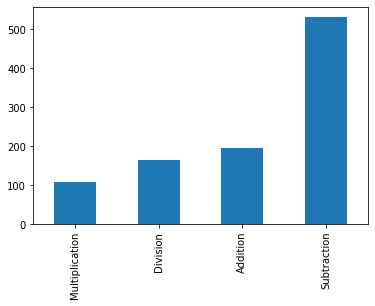

In [37]:
df.Type.value_counts().sort_values().plot(kind = 'bar')

#### 1.3.2 Remove Punctuation

I am removing all punctuation AND numbers from the body cuz I think it's irrelevent to my task of multi-class text classification.
If something's not working, toggle:
- the numbers
- ~~Stopwords~~

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [23]:
def clean_text(text):
    """
    text: a string

    return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    # text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [9]:
punct_toRemove = '!"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'

In [27]:
#storing the puntuation free text
df['Clean']= df['BQ'].apply(lambda x:clean_text(x))
df['Clean'] = df['Clean'].str.replace('[0-9]+', '')
df['Clean'] = df['Clean'].apply(lambda x: " ".join(x.split()))
df['Clean'][1]

C:\Users\d3583\AppData\Local\Temp\ipykernel_10936\262170022.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Clean'] = df['Clean'].str.replace('[0-9]+', '')


'dan had left with him after he bought a candy bar if he had at the start how much did the candy bar cost'

In [ ]:
df['BQ'] = 

## 2. Build Model
4 classes are ['Subtraction', 'Addition', 'Multiplication', 'Division']

In [11]:
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dropout
from keras.layers import  Dense, Embedding, LSTM, Bidirectional

2.1 Define the Classes of the Multi-class Text Classification

In [28]:
operations = ['Subtraction', 'Addition', 'Multiplication', 'Division']

### 2.2 Vectorize our MWP

### 2.3 Set Parameters of the Model